# Kernel Methods
During this exercise session we will analyse the use of kernel methods to perform regression and classification tasks.
At first, we use Gaussian process to compute the value of the petal width given the petal length in the Iris dataset. After that, we use SVMs to classify the setosa and non-setosa flowers.



## Gaussian Process

In [ ]:
import numpy as np
from scipy.stats import zscore
from sklearn import datasets

dataset = datasets.load_iris()

x = zscore(dataset.data[:, 2]).reshape(-1, 1) # column 2 of data is petal length
t = zscore(dataset.data[:, 3]) # column 3 of data is petal width

Once we have our dataset, we would like to set up a GP for regression

At first we set up our kernel. In this case we choose a standard Gaussian kernel, a.k.a. RBF kernel:
$$K(\mathbf{x}, \mathbf{y}) : = \phi \exp \left\{ - \frac{||\mathbf{x} - \mathbf{y}||_2^2}{2 l^2} \right\}$$

Moreover, we have to choose the value of the variance $\sigma^2$ of the noise of the data we are considering.

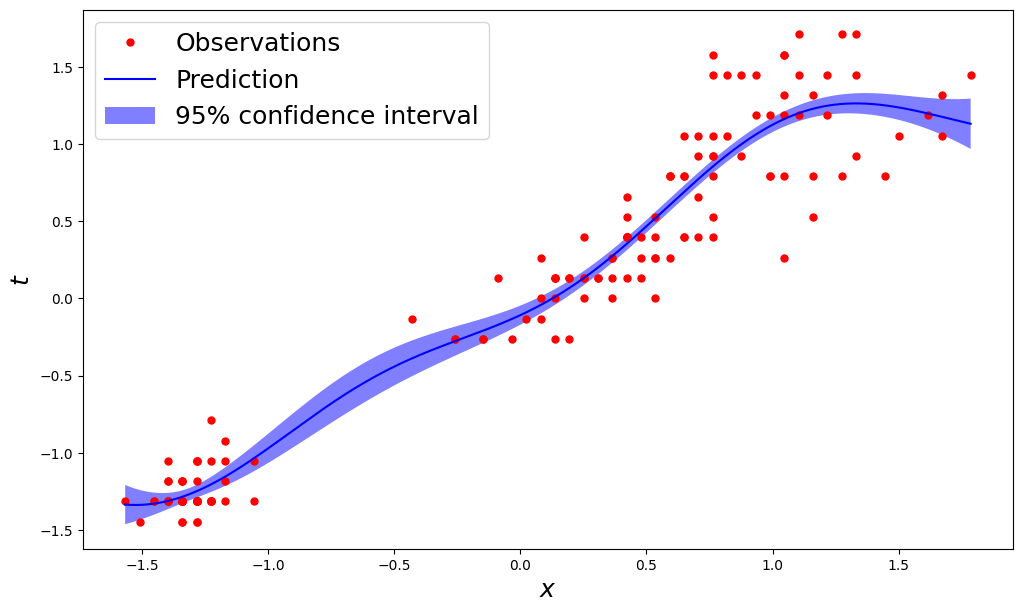

In [ ]:
from sklearn.gaussian_process import GaussianProcessRegressor
from matplotlib import pyplot as plt
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

#Kernel values
phi = 0.7
l = 0.9
sigma_sq = 0.02
kernel = ConstantKernel(phi, constant_value_bounds="fixed") * RBF(l, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_sq).fit(x, t)
x_pred = np.linspace(np.min(x),np.max(x),5000).reshape(-1,1)
t_pred, sigma = gpr.predict(x_pred, return_std=True)
plt.figure(figsize=(12,7))
plt.plot(x, t, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, t_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([t_pred - 1.9600 * sigma,
                        (t_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$t$', fontsize=18)
plt.legend(loc='upper left', fontsize=18)

Changing the values of the kernel parameters influences the dynamic of the GP
For instance if:
- set $l = 8$ we increase the smoothness of the GP
- set $\sigma^2 = 10$ we increase the noise in each point
- set $\phi = 100$ we increase the influence of the kernel to the results


To optimize these parameters before starting the regression procedure, we can use either an independent dataset or cross-validation to estimate them, maximizing the likelihood of the considered samples. In what follows, we will use the points from the Iris dataset to optimize the parameter $l$ and $\phi$.

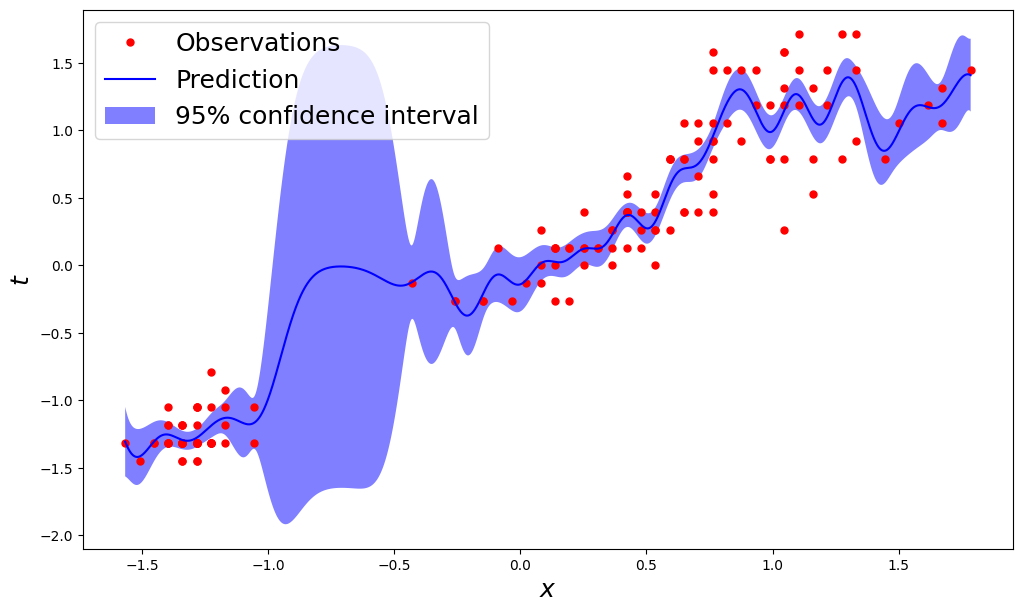

In [ ]:
kernel = ConstantKernel(phi, constant_value_bounds="fixed") * RBF(0.1, length_scale_bounds="fixed")
gpr = GaussianProcessRegressor(kernel=kernel, alpha=sigma_sq).fit(x, t)
x_pred = np.linspace(np.min(x),np.max(x),5000).reshape(-1,1)
t_pred, sigma = gpr.predict(x_pred, return_std=True)
plt.figure(figsize=(12,7))
plt.plot(x, t, 'r.', markersize=10, label='Observations')
plt.plot(x_pred, t_pred, 'b-', label='Prediction')
plt.fill(np.concatenate([x_pred, x_pred[::-1]]),
         np.concatenate([t_pred - 1.9600 * sigma,
                        (t_pred + 1.9600 * sigma)[::-1]]),
         alpha=.5, fc='b', ec='None', label='95% confidence interval')
plt.xlabel('$x$', fontsize=18)
plt.ylabel('$t$', fontsize=18)
plt.legend(loc='upper left', fontsize=18)

In [ ]:
gpr.kernel_

Finally, a useful resource for GPs https://thegradient.pub/gaussian-process-not-quite-for-dummies/

## SVM
The application of kernel methods to classification is easily exemplified in the SVMs

We start with the linear formulation, for which we are applying a linear kernel $K(\mathbf{x}, \mathbf{y}) = \mathbf{x}^\top \mathbf{y}$



In [ ]:
from sklearn import svm

input = zscore(dataset.data[:, [0, 1]]) # column 0,1 are sepal length and sepal width

# the dataset is stored in the variable iris
target = dataset.target.copy()
# 0 - setosa, 1 - versicolor, 2 - virginica
target[target == 1] = 2
target[target == 0] = 1
target[target == 2] = 0

SVM_model = svm.SVC(kernel='linear')
SVM_model.fit(input, target)

#check the support vectors
SVM_model.support_vectors_

array([[-0.7795133 , -0.82256978],
       [-0.29484182, -0.13197948],
       [-0.53717756, -0.13197948],
       [ 0.18982966,  0.78880759],
       [-0.29484182, -0.13197948],
       [-1.14301691, -1.28296331],
       [-1.14301691, -0.13197948],
       [-0.53717756,  0.78880759],
       [-1.02184904, -0.13197948],
       [-0.53717756,  0.78880759],
       [-0.41600969,  1.01900435],
       [-1.62768839, -1.74335684]])

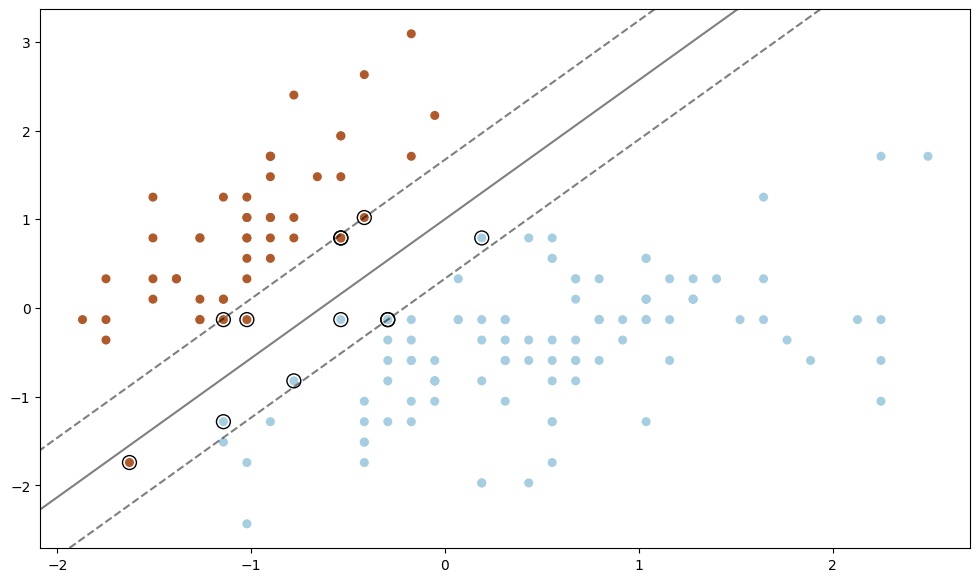

In [ ]:
plt.figure(figsize=(12,7))

plt.scatter(input[:, 0], input[:, 1], c=target, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
#evaluate the SVM value for the positive class
Z = SVM_model.decision_function(xy).reshape(XX.shape)

# plot decision boundary (w^Tx =  0) and margins (w^Tx = 1 and w^Tx = -1)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(SVM_model.support_vectors_[:, 0], SVM_model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()



Instead, if we want to add a Gaussian kernel (or RBF):
$$ K(\mathbf{x}, \mathbf{y}) = \exp \left\{ - \frac{||\mathbf{x} - \mathbf{y}||^2}{l} \right\} $$


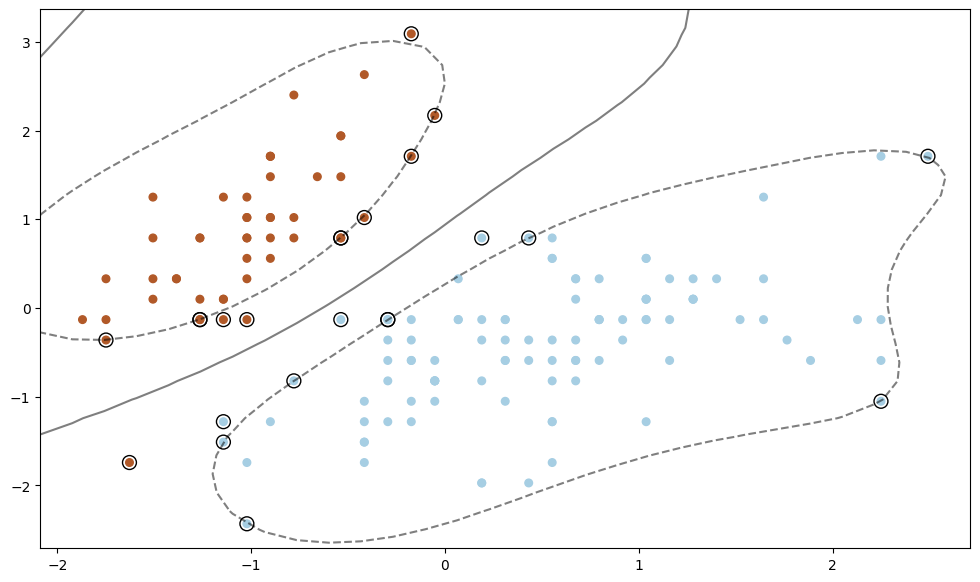

In [ ]:
SVM_model = svm.SVC() # default kernel is 'rbf'
#default scale coefficient (gamma="scale", corresponding to 1/l) is a heuristic value
SVM_model.fit(input, target)

plt.figure(figsize=(12,7))

plt.scatter(input[:, 0], input[:, 1], c=target, s=30, cmap=plt.cm.Paired)

# plot the decision function
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
#evaluate the SVM value for the positive class
Z = SVM_model.decision_function(xy).reshape(XX.shape)

# plot decision boundary (w^Tx =  0) and margins (w^Tx = 1 and w^Tx = -1)
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5,
           linestyles=['--', '-', '--'])
# plot support vectors
ax.scatter(SVM_model.support_vectors_[:, 0], SVM_model.support_vectors_[:, 1], s=100,
           linewidth=1, facecolors='none', edgecolors='k')
plt.show()

The margins are not linear anymore. We still have the support vectors (How can we identify them?) which are those data that are used to provide a prediction.

## Homeworks

Here we propose some exercises in python for you. They are not mandatory, but they can be helpful to better understand the contents of the lecture, by giving you the opportunity to develop some code by yourself.

1) Predicting petal width

Consider again the Iris dataset, and write a code to predict the petal width by using, this time, all the other features as input. Use as predictor the GP model.

2) Using GP for classification

Instead use GP as a classification tool to predict setosa vs. non-setosa flowers. Use the appropriate techniques to determinte the performance of this methods we might have on newly seen data. Is the mean squared error a good performance metric even under the probabilistic model provided by GPs?

3) Implementing SVM for multiple outputs

Extend the SVM to predict the three classes present in the Iris Dataset. Do we need to apply a specific methods to handle the three classes?
Compare the results obtained with the ones provided by other classification methods presented during the course.